# ЛР2. Разработка полносвязной сети

In [1]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!cp /content/gdrive/'My Drive'/datasets/gtsrb-german-traffic-sign.zip .

import zipfile
with zipfile.ZipFile('gtsrb-german-traffic-sign.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

!ls

gdrive			       meta  Meta.csv	  test	Test.csv  Train
gtsrb-german-traffic-sign.zip  Meta  sample_data  Test	train	  Train.csv


In [3]:
%tensorflow_version 2.x
import os
import cv2
import numpy as np
import csv
from time import time
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

TensorFlow 2.x selected.


### Описание датасета

Рассматривается задача классификации [немецких дорожных знаков](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) *GTSRB - German Traffic Sign Recognition Benchmark*.

* Train, train.csv - размеченные данные
* Test, Test.scv - тестовые данные
* Meta, Meta.csv - дополнительные данные

Для экспериментах задействованы обучающие и тестовые данные. 
Обучающая выборка содержит 43 класса.

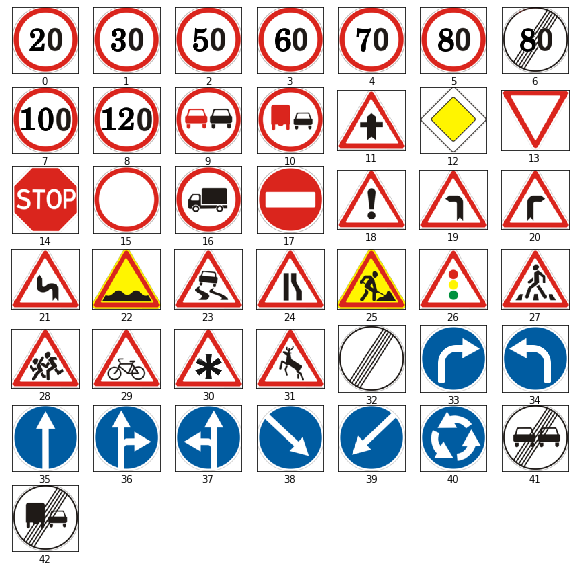

In [4]:
plt.figure(figsize=(10, 10))
for i in range (0,43):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path = "meta/{0}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(i)

### Загружаем данные

In [0]:
# Предообработка данных
def preprocess(image, out_side):
	height, width = image.shape[:2]
	scale = out_side / max(height, width)
	dx = (out_side - scale * width) / 2
	dy = (out_side - scale * height) / 2
	trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
	image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
	return image

# Перемешивание данных
def mixing(images, labels):
		images = np.array(images)
		labels = np.array(labels)
		s = np.arange(images.shape[0])
		np.random.seed(43)
		np.random.shuffle(s)
		images=images[s]
		labels=labels[s]
		return images, labels

# Загрузка тренировочных данных
def load_train(path, out_side):
	images = []
	labels = []
	for folder in os.listdir(os.path.join(path, 'Train')):
		cur_path = os.path.join(path, 'Train', folder)
		for file_name in os.listdir(cur_path):
			image = cv2.imread(os.path.join(cur_path, file_name))
			images.append(preprocess(image, out_side))
			labels.append(int(folder))
	
	return mixing(images, labels)

# Загрузка тестовых данных
def load_test(path, out_side):
	images = []
	labels = []
	with open(os.path.join(path, 'Test.csv'), 'r') as f:
		reader = csv.reader(f)
		for rows in reader:
			name = rows[7]
			if (name == 'Path'):
				continue
			image = cv2.imread(os.path.join(path, rows[7]))
			images.append(preprocess(image, out_side))
			labels.append(int(rows[6]))
	
	return mixing(images, labels)

In [6]:
start = time()

# Загружаем предобработанные изображения в разрешении 50x50
train_images, train_labels = load_train(".", 50)
test_images, test_labels = load_test(".", 50)
shape = train_images[0].shape
print(shape)

# Нормализуем данные
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

# Преобразуем метки в one-hot-encoding
train_labels = utils.to_categorical(train_labels, 43)
test_labels = utils.to_categorical(test_labels, 43)

print('Loading: ', time() - start)

(50, 50, 3)
Loading:  9.801161527633667


In [7]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((39209, 50, 50, 3), (12630, 50, 50, 3), (39209, 43), (12630, 43))

### Запускаем сеть

In [0]:
classes = 43 # Количество классов изображений
batch = 256 # Размер мини-выборки
epochs = 20 # Количество эпох для обучения
learning_rate = 0.001 # Коэффициент скорости обучения

def results(model):
  adam = Adam(lr=learning_rate)

  # Компилируем модель
  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  # Обучаем модель
  start = time()
  history = model.fit(train_images, train_labels, batch_size=batch, epochs=epochs, validation_split=0.2, shuffle = True, verbose=1)
  train_time = time() - start

  # Архитектура сети
  model.summary()

  # Графики изменения метрик
  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  # Запускаем на тестовых данных
  start = time()
  test_loss, test_acc = model.evaluate(test_images, test_labels)
  test_time = time() - start
  print('\nTrain time: ', train_time)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)
  print('Test time: ', test_time)

#### Конфигурация №1

Train on 31367 samples, validate on 7842 samples
Epoch 1/20
31367/31367 [==============================] - 3s 103us/sample - loss: 2.8526 - accuracy: 0.3719 - val_loss: 1.9135 - val_accuracy: 0.5352
Epoch 2/20
31367/31367 [==============================] - 1s 38us/sample - loss: 1.5108 - accuracy: 0.6514 - val_loss: 1.2939 - val_accuracy: 0.6872
Epoch 3/20
31367/31367 [==============================] - 1s 36us/sample - loss: 1.0587 - accuracy: 0.7643 - val_loss: 0.9164 - val_accuracy: 0.8115
Epoch 4/20
31367/31367 [==============================] - 1s 34us/sample - loss: 0.8073 - accuracy: 0.8270 - val_loss: 0.7484 - val_accuracy: 0.8415
Epoch 5/20
31367/31367 [==============================] - 1s 34us/sample - loss: 0.6602 - accuracy: 0.8601 - val_loss: 0.6397 - val_accuracy: 0.8499
Epoch 6/20
31367/31367 [==============================] - 1s 34us/sample - loss: 0.5530 - accuracy: 0.8811 - val_loss: 0.5389 - val_accuracy: 0.8907
Epoch 7/20
31367/31367 [==============================] 

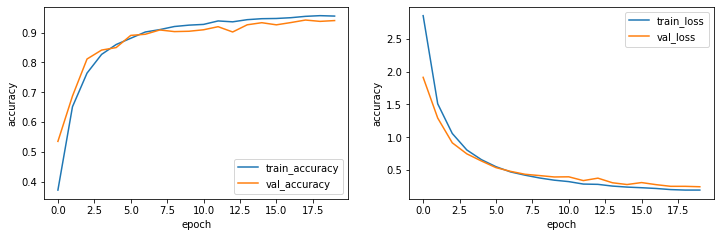

12630/12630 [==============================] - 1s 88us/sample - loss: 0.8189 - accuracy: 0.8362

Train time:  24.765449047088623
Test accuracy: 0.83618367
Test loss: 0.8189256346423949
Test time:  1.1377761363983154


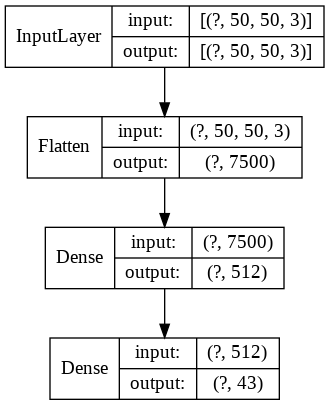

In [9]:
# Создаём модель
model = Sequential()
model.add(Flatten(input_shape=(50, 50, 3)))
model.add(Dense(512, activation='relu'))
model.add(Dense(classes, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №2

Train on 31367 samples, validate on 7842 samples
Epoch 1/20
31367/31367 [==============================] - 1s 45us/sample - loss: 2.3673 - accuracy: 0.4094 - val_loss: 1.5608 - val_accuracy: 0.6254
Epoch 2/20
31367/31367 [==============================] - 1s 34us/sample - loss: 1.1646 - accuracy: 0.7309 - val_loss: 0.8762 - val_accuracy: 0.8132
Epoch 3/20
31367/31367 [==============================] - 1s 34us/sample - loss: 0.7290 - accuracy: 0.8453 - val_loss: 0.6241 - val_accuracy: 0.8694
Epoch 4/20
31367/31367 [==============================] - 1s 37us/sample - loss: 0.5206 - accuracy: 0.8920 - val_loss: 0.4935 - val_accuracy: 0.8934
Epoch 5/20
31367/31367 [==============================] - 1s 36us/sample - loss: 0.4052 - accuracy: 0.9190 - val_loss: 0.3772 - val_accuracy: 0.9249
Epoch 6/20
31367/31367 [==============================] - 1s 36us/sample - loss: 0.3254 - accuracy: 0.9360 - val_loss: 0.3206 - val_accuracy: 0.9294
Epoch 7/20
31367/31367 [==============================] -

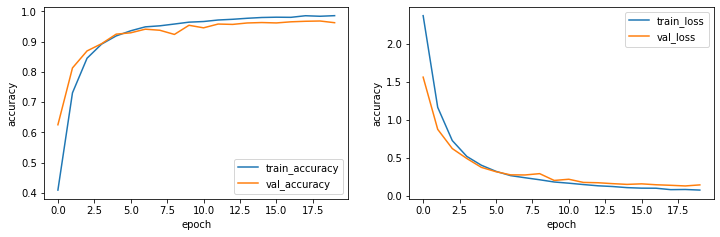

12630/12630 [==============================] - 1s 89us/sample - loss: 0.5717 - accuracy: 0.8530

Train time:  23.187788009643555
Test accuracy: 0.8529691
Test loss: 0.5717077059304063
Test time:  1.1545848846435547


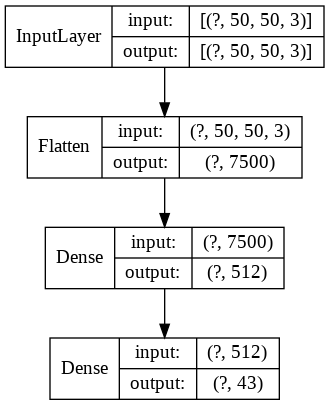

In [10]:
# Создаём модель
model = Sequential()
model.add(Flatten(input_shape=(50, 50, 3)))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(classes, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №3

Train on 31367 samples, validate on 7842 samples
Epoch 1/20
31367/31367 [==============================] - 2s 54us/sample - loss: 2.9145 - accuracy: 0.3424 - val_loss: 1.8489 - val_accuracy: 0.5233
Epoch 2/20
31367/31367 [==============================] - 1s 38us/sample - loss: 1.3171 - accuracy: 0.6686 - val_loss: 1.0256 - val_accuracy: 0.7298
Epoch 3/20
31367/31367 [==============================] - 1s 38us/sample - loss: 0.8039 - accuracy: 0.8009 - val_loss: 0.7383 - val_accuracy: 0.8097
Epoch 4/20
31367/31367 [==============================] - 1s 37us/sample - loss: 0.5950 - accuracy: 0.8500 - val_loss: 0.5023 - val_accuracy: 0.8787
Epoch 5/20
31367/31367 [==============================] - 1s 39us/sample - loss: 0.4310 - accuracy: 0.8983 - val_loss: 0.4272 - val_accuracy: 0.8925
Epoch 6/20
31367/31367 [==============================] - 1s 37us/sample - loss: 0.4318 - accuracy: 0.8905 - val_loss: 0.3869 - val_accuracy: 0.9014
Epoch 7/20
31367/31367 [==============================] -

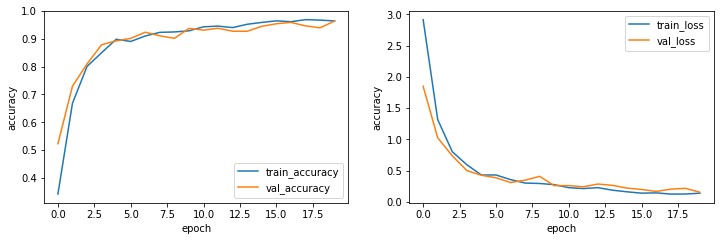

12630/12630 [==============================] - 1s 86us/sample - loss: 0.9557 - accuracy: 0.8401

Train time:  24.57745051383972
Test accuracy: 0.8401425
Test loss: 0.9557247480322988
Test time:  1.1134016513824463


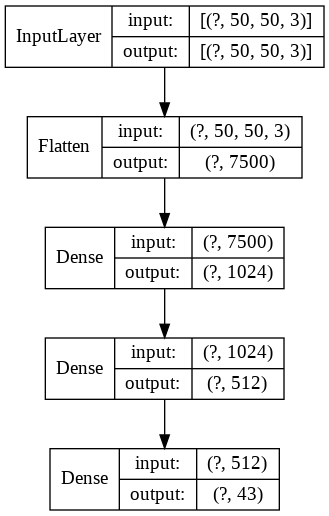

In [11]:
# Создаём модель
model = Sequential()
model.add(Flatten(input_shape=(50, 50, 3)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(classes, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Конфигурация №4

Train on 31367 samples, validate on 7842 samples
Epoch 1/20
31367/31367 [==============================] - 2s 52us/sample - loss: 2.4269 - accuracy: 0.3478 - val_loss: 1.4616 - val_accuracy: 0.5940
Epoch 2/20
31367/31367 [==============================] - 1s 37us/sample - loss: 1.0161 - accuracy: 0.7318 - val_loss: 0.7332 - val_accuracy: 0.8159
Epoch 3/20
31367/31367 [==============================] - 1s 37us/sample - loss: 0.5685 - accuracy: 0.8578 - val_loss: 0.4673 - val_accuracy: 0.8815
Epoch 4/20
31367/31367 [==============================] - 1s 38us/sample - loss: 0.3725 - accuracy: 0.9125 - val_loss: 0.3421 - val_accuracy: 0.9151
Epoch 5/20
31367/31367 [==============================] - 1s 37us/sample - loss: 0.2872 - accuracy: 0.9334 - val_loss: 0.2666 - val_accuracy: 0.9375
Epoch 6/20
31367/31367 [==============================] - 1s 37us/sample - loss: 0.2468 - accuracy: 0.9392 - val_loss: 0.2910 - val_accuracy: 0.9277
Epoch 7/20
31367/31367 [==============================] -

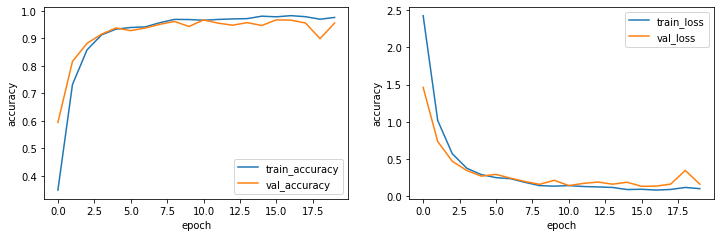

12630/12630 [==============================] - 1s 84us/sample - loss: 0.6856 - accuracy: 0.8329

Train time:  24.252079963684082
Test accuracy: 0.8329375
Test loss: 0.6855566248474665
Test time:  1.0852577686309814


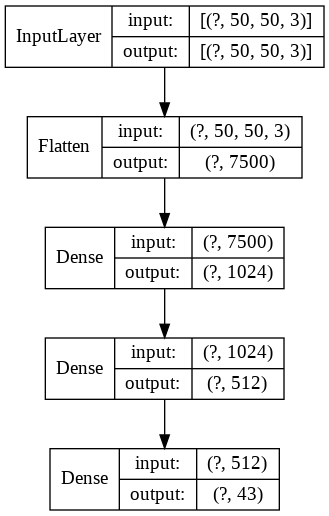

In [12]:
# Создаём модель
model = Sequential()
model.add(Flatten(input_shape=(50, 50, 3)))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(classes, activation='softmax'))

results(model)
utils.plot_model(model, show_shapes=True, show_layer_names=False)